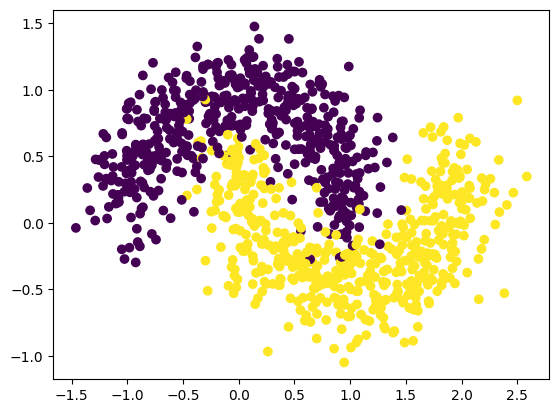

In [126]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

data = make_moons(1000,noise=0.2)
X = data[0]
y = data[1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [127]:
#Neural network basics
class Layer:
    def __init__(self,no_inputs,neuron):
        self.weights = 0.1*np.random.randn(no_inputs,neuron)
        self.bias = np.zeros((1,neuron))
    def forward(self,X):
        self.inputs = X
        return np.dot(X,self.weights)+self.bias
    def backward(self,dvals):
        self.dweights = np.dot(self.inputs.T,dvals)
        self.dbias = np.sum(dvals,axis=0,keepdims=True)
        
        #backpropagation dL/dX <- getting propagated to previous layer
        return np.dot(dvals,self.weights.T)
    
class Relu:
    def __init__(self):
        pass
    def forward(self,X):
        self.output = np.maximum(X,0)
        return self.output
    def backward(self,dvals):
        dvals = dvals.copy()
        dvals[self.output <= 0] = 0
        return dvals

class Sigmoid:
    def __init__(self):
        pass
    def forward(self,X):
        X = np.clip(X, -500, 500)
        self.output = 1/(1+np.exp(-X))
        return self.output
    def backward(self,dvals):
        # backpropagation
        return dvals*(self.output*(1-self.output))

class SGDLossBCE:
    def __init__(self):
        pass
    def loss(self,true,pred):
        true = true.reshape(-1,1)
        eps = 1e-7
        pred = np.clip(pred, eps, 1 - eps) #this is must to avoid some Numerical based errors
        return -np.mean(true*np.log(pred)+(1-true)*np.log(1-pred))
    #backpropagation
    def backward(self,true,pred):
        n=true.shape[0]
        true = true.reshape(-1,1)
        eps = 1e-7 
        pred = np.clip(pred, eps, 1 - eps) #this is must to avoid some Numerical based errors
        return (-(true/pred)+((1-true)/(1-pred)))/n    

In [128]:
#optimization
class LearningRateDecay:
    def __init__(self,learning_rate,decay=1e-3):
        self.learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
    def learningRate(self):
        self.iteration+=1
        return self.learning_rate/(1+self.decay*self.iteration) 
    
class Momentum:
    def __init__(self,momentum_factor):
        self.momentum_factor = momentum_factor
    
    def update_weights(self,layers,lr):
        for [layer,_] in reversed(layers):
            if not hasattr(layer, 'weight_momentum'):
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.bias)
            
            layer.weight_momentum = self.momentum_factor*layer.weight_momentum-lr*layer.dweights
            layer.bias_momentum = self.momentum_factor*layer.bias_momentum-lr*layer.dbias
            
            layer.weights += layer.weight_momentum
            layer.bias += layer.bias_momentum

class AdaGrad:
    def __init__(self):
        pass
    def update_weights(self,layers,lr, epsilon=1e-7):
        for [layer,_] in reversed(layers):
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.bias)
            
            layer.weight_cache += layer.dweights**2
            layer.bias_cache += layer.dbias**2
            
            layer.weights -= (lr*layer.dweights)/np.sqrt(layer.weight_cache+epsilon)
            layer.bias -= (lr*layer.dbias)/np.sqrt(layer.bias_cache+epsilon)

class RMSProp:
    def __init__(self):
        pass
    def update_weights(self,layers,lr,rho=0.9,epsilon=1e-7):
        for [layer,_] in reversed(layers):
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.bias)
            
            layer.weight_cache =rho*layer.weight_cache+(1-rho)*layer.dweights**2
            layer.bias_cache = rho*layer.bias_cache+(1-rho)*layer.dbias**2
            
            layer.weights -= (lr*layer.dweights)/np.sqrt(layer.weight_cache+epsilon)
            layer.bias -= (lr*layer.dbias)/np.sqrt(layer.bias_cache+epsilon)

class Adam:
    def __init__(self):
       pass
    def update_weights(self,layers,lr,iteration,epsilon=1e-7,beta1=0.9, beta2=0.999):
        for [layer,_] in reversed(layers):
            if not hasattr(layer, 'weight_momentum'):
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.bias)
            
            layer.weight_momentum = beta1*layer.weight_momentum+(1-beta1)*layer.dweights
            layer.bias_momentum = beta1*layer.bias_momentum+(1-beta1)*layer.dbias
                
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.bias)
            
            layer.weight_cache =beta2*layer.weight_cache+(1-beta2)*layer.dweights**2
            layer.bias_cache = beta2*layer.bias_cache+(1-beta2)*layer.dbias**2
            
            layer.weights-=lr*(layer.weight_momentum/(1-beta1**iteration))/np.sqrt((layer.weight_cache/(1-beta2**iteration))+epsilon)
            layer.bias-=lr*(layer.bias_momentum/(1-beta1**iteration))/np.sqrt((layer.bias_cache/(1-beta2**iteration))+epsilon)    

In [135]:
class NN:
    def __init__(self,neurons,no_inputs,lr=1):
        self.lr = lr
        self.layers = []
        self.loss = SGDLossBCE()
        current_input_size = no_inputs
        for i in neurons:
            layer = Layer(current_input_size,i)
            activation = Relu()
            self.layers.append([layer,activation])
            
            current_input_size = i
        
        output_layer = Layer(current_input_size,1)
        output_activation = Sigmoid()
        
        self.layers.append([output_layer,output_activation])
        
    def forward(self,X):
        current_output = X
        
        for [layer,activation] in self.layers:
            current_output = activation.forward(layer.forward(current_output))
        
        return current_output
    
    def backward(self,loss):
        dval = loss
        for [layer,activation] in reversed(self.layers):
            dval = activation.backward(dval)
            dval = layer.backward(dval)
            
    def predict(self,X):
        output = self.forward(X)
        return (output > 0.5).astype(int)        
    
    def backward_update(self,lr):
        for [layer,_] in reversed(self.layers):
            layer.weights-=lr*layer.dweights
            layer.bias-=lr*layer.dbias
    
    def backpropagation(self,X,true,epoch,method='Decay'):
        self.epoch = epoch
        self.lr_decay = LearningRateDecay(self.lr)
        optimizer = None
        
        if method == 'Momentum':
            optimizer = Momentum(0.9)
        elif method == 'AdaGrad':
            optimizer = AdaGrad()
        elif method == 'RMSProp':
            optimizer = RMSProp()
        elif method == 'Adam':
            optimizer = Adam()
            
        for i in range(self.epoch):
            pred = self.forward(X)
            loss_propagation = self.loss.backward(true,pred)
            self.backward(loss_propagation)
            learning_rate = self.lr_decay.learningRate()
            if method == 'Decay':
                self.backward_update(learning_rate)
            elif method == 'Momentum':
                optimizer.update_weights(self.layers,learning_rate)
            elif method == 'AdaGrad':
                optimizer.update_weights(self.layers,learning_rate)
            elif method == 'RMSProp':
                optimizer.update_weights(self.layers,learning_rate)   
            elif method == 'Adam':
                optimizer.update_weights(self.layers,learning_rate,self.lr_decay.iteration)
                  

In [136]:
optimizers = ['Decay','Momentum','AdaGrad','RMSProp','Adam']

In [140]:
for i in optimizers:
    model = NN([10,5],X.shape[1])
    model.backpropagation(X_train,y_train,10000,i)
    pred = model.predict(X_test)
    from sklearn.metrics import accuracy_score
    print(f'{i} : {accuracy_score(y_test,pred)}')

Decay : 0.8833333333333333
Momentum : 0.9733333333333334
AdaGrad : 0.97
RMSProp : 0.48333333333333334
Adam : 0.98
